# <center> **Project 5. New York City Taxi Trip Duration**

**Descriprion**  
Based on [the Kaggle competition](https://www.kaggle.com/competitions/nyc-taxi-trip-duration).  
In this competition, Kaggle is challenging you to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.  

**Business problem:** determine the characteristics and use them to predict the duration of a taxi ride.  
**The technical task:** to build a machine learning model that, based on the proposed characteristics of the client, will predict a numerical feature - the taxi ride time.

**Target metric**  
The evaluation metric for this competition is [Root Mean Squared Logarithmic Error](https://hrngok.github.io/posts/metrics/#:~:text=Root%20Mean%20Squared%20Logaritmic%20Error%20(RMSLE)&text=It%20is%20the%20Root%20Mean,possible%200%20(zero)%20values.).

**About data**  
- id - a unique identifier for each trip
- vendor_id - a code indicating the provider associated with the trip record
- pickup_datetime - date and time when the meter was engaged
- dropoff_datetime - date and time when the meter was disengaged
- passenger_count - the number of passengers in the vehicle (driver entered value)
- pickup_longitude - the longitude where the meter was engaged
- pickup_latitude - the latitude where the meter was engaged
- dropoff_longitude - the longitude where the meter was disengaged
- dropoff_latitude - the latitude where the meter was disengaged
- store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server: 
    - Y=store and forward;
    - N=not a store and forward trip
- trip_duration - duration of the trip in seconds

In [1]:
# main
import pandas as pd
import numpy as np
from scipy import stats

from scipy.stats import normaltest
from pandas_profiling import ProfileReport

# sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, f_regression, RFE
from sklearn import ensemble, metrics, tree, linear_model
from sklearn.preprocessing import PolynomialFeatures

# machine learning
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.model_selection import cross_val_score, cross_validate
import optuna
import hyperopt
from hyperopt import hp, fmin, tpe, Trials, space_eval

# ensembles
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingRegressor, StackingClassifier
from sklearn.ensemble import IsolationForest

# pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
import joblib

# coders
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from category_encoders import BinaryEncoder, OrdinalEncoder

# visualisation
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib import colors
from matplotlib.colors import ListedColormap
import plotly.graph_objs as go

In [2]:
pd.set_option('display.max_columns', None)

## <center> **Part I. Loading and exploring**

In [3]:
# load and display train part of data
train_data = pd.read_csv('files/train.csv')
test_data = pd.read_csv('files/test.csv')

In [4]:
# mark the train and the test sample
train_data['sample'] = 1
test_data['sample'] = 0

# we ought to predict this value, what's why equate the value to 0 for now
test_data['trip_duration'] = 0

# concat train and test to common data set
data = test_data.append(train_data, sort=False).reset_index(drop=True)

C:\Users\volod\AppData\Local\Temp\ipykernel_7028\2779665835.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = test_data.append(train_data, sort=False).reset_index(drop=True)


In [5]:
data.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,sample,trip_duration,dropoff_datetime
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N,0,0,NaN
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N,0,0,NaN
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N,0,0,NaN
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N,0,0,NaN
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N,0,0,NaN


In [6]:
# check for gaps
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2083778 entries, 0 to 2083777
Data columns (total 12 columns):
 #   Column              Dtype  
---  ------              -----  
 0   id                  object 
 1   vendor_id           int64  
 2   pickup_datetime     object 
 3   passenger_count     int64  
 4   pickup_longitude    float64
 5   pickup_latitude     float64
 6   dropoff_longitude   float64
 7   dropoff_latitude    float64
 8   store_and_fwd_flag  object 
 9   sample              int64  
 10  trip_duration       int64  
 11  dropoff_datetime    object 
dtypes: float64(4), int64(4), object(4)
memory usage: 190.8+ MB


In [7]:
data.isnull().sum()

id                         0
vendor_id                  0
pickup_datetime            0
passenger_count            0
pickup_longitude           0
pickup_latitude            0
dropoff_longitude          0
dropoff_latitude           0
store_and_fwd_flag         0
sample                     0
trip_duration              0
dropoff_datetime      625134
dtype: int64

## <center> **Part II. Feature engineering**

First, let's look at the time frame in the data. We should create some new features.

In [8]:
# transform to datetime
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')

In [9]:
# let's describe our target value
train_mask = data[data['sample'] == 1] 
round(train_mask['trip_duration'].describe())

count    1458644.0
mean         959.0
std         5237.0
min            1.0
25%          397.0
50%          662.0
75%         1075.0
max      3526282.0
Name: trip_duration, dtype: float64

What did we find out? The data includes trips that are one second long, as well as trips that are longer than 40 days. Immediately comes the thought that these are outliers.

Upon further analysis, it turns out that we also have "teleportations" - trips that were made in seconds over long distances.

The data is divided into test and training parts. Since we will apply all data manipulations on both data sets, in order to avoid code duplication, we will preprocess using functions. Also it looks more professionally.

In [10]:
def add_datetime_features(df):
    """func to extract new time feature

    Args: dataframe

    Returns: modified df
    """
    
    df['pickup_date'] = df['pickup_datetime'].dt.date
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_day_of_week'] = df['pickup_datetime'].dt.day_name()
    
    return df

In [11]:
# apply this feature to train sample
data = add_datetime_features(data)

The situation on the roads often depends on whether the day is a holiday. A large number of cars creates traffic jams and potentially increases the duration of a taxi trip.

Let's add information to our dataset about whether the day is a holiday.

In [12]:
# load data with holidays
holidays = pd.read_csv('files/holiday_data.csv', sep=';')

# transform to useful format
holidays['date'] = pd.to_datetime(holidays['date'])

# extract the date
holidays['date'] = holidays['date'].dt.date

In [13]:
def add_holiday_feature(df, holidays):
    """func to determine if a day is a holiday

    Args:
        df (df): initial df
        holidays (df): df with all holidays

    Returns:
        df: modified df with new binary feature of holiday
    """
    
    # connect both datasets
    df_merged = df.merge(
        holidays,
        left_on= 'pickup_date',
        right_on = 'date',
        how='left'
        )
    
    # fill in the gaps - the gaps means no holiday
    df_merged = df_merged.fillna(0)
    
    # replace the name of the holiday with 1 - the presence of a holiday
    df_merged['pickup_holiday'] = df_merged['holiday'].apply(lambda x: 0 if x==0 else 1)
    df_merged = df_merged.drop(['day', 'date', 'holiday'], axis=1)
    
    return df_merged

In [14]:
# apply this feature to our dataset
data = add_holiday_feature(data, holidays)

Now that we have dealt with temporal characteristics, let's move on to geographic ones. Knowing the latitude and longitude of the start and end points of the route, we can use the [OSRM API](https://www.thinkdatascience.com/post/2020-03-03-osrm/osrm/). The datasets are presented in tabular CSV format.

In [15]:
# load osrm for the train sample
osrm_train = pd.read_csv('files/osrm_data_train.csv')

# load osrm for the test sample
osrm_test = pd.read_csv('files/Project5_osrm_data_test.csv')

In [16]:
# join these samples and display
osrm = pd.concat([osrm_train, osrm_test])
osrm.head()

,id,starting_street,end_street,total_distance,total_travel_time,number_of_steps,street_for_each_step,distance_per_step,travel_time_per_step,step_maneuvers,step_direction,step_location_list
0,id2875421,Columbus Circle,East 65th Street,2009.1,164.9,5,Columbus Circle|Central Park West|65th Street ...,0|576.4|885.6|547.1|0,0|61.1|60.1|43.7|0,depart|rotary|turn|new name|arrive,left|straight|right|straight|arrive,"-73.982316,40.767869|-73.981997,40.767688|-73...."
1,id2377394,2nd Avenue,Washington Square West,2513.2,332.0,6,2nd Avenue|East 13th Street|5th Avenue|Washing...,877.3|836.5|496.1|164.2|139.1|0,111.7|109|69.9|25.8|15.6|0,depart|turn|turn|end of road|continue|arrive,none|right|left|right|left|arrive,"-73.980429,40.73857|-73.985444,40.731658|-73.9..."
2,id3504673,Greenwich Street,Broadway,1779.4,235.8,4,Greenwich Street|Park Place|Broadway|Broadway,644.2|379.9|755.3|0,80.5|50.8|104.5|0,depart|turn|end of road|arrive,left|left|right|arrive,"-74.010145,40.719982|-74.011527,40.714294|-74...."
3,id2181028,Broadway,West 81st Street,1614.9,140.1,5,Broadway|West 86th Street|Columbus Avenue|West...,617|427.4|412.2|158.3|0,56|36|37.8|10.3|0,depart|turn|turn|turn|arrive,right|left|right|left|arrive,"-73.972998,40.793187|-73.976607,40.788361|-73...."
4,id0801584,Lexington Avenue,West 31st Street,1393.5,189.4,5,Lexington Avenue|East 27th Street|Madison Aven...,18.9|311.9|313.3|749.4|0,6.3|42.9|48.4|91.8|0,depart|turn|turn|turn|arrive,right|right|right|left|arrive,"-73.982805,40.742173|-73.982914,40.742024|-73...."


In [17]:
# create a list of 200 the most popular starting street
popular_start_street = osrm['starting_street'].value_counts().nlargest(200).index.to_list()

# change not popular street to other
osrm['starting_street'] = osrm['starting_street'].apply(lambda x: x if x in popular_start_street else 'other')


In [18]:
# create a list of 250 the most popular ending street
popular_end_street = osrm['end_street'].value_counts().nlargest(250).index.to_list()

# change not popular street to other
osrm['end_street'] = osrm['end_street'].apply(lambda x: x if x in popular_end_street else 'other')

Let's leave only the following columns:
- *id* — trip id;
- *total_distance* - the shortest road distance (in meters) from the point at which the counter was turned on to the point at which the counter was turned off (according to OSRM);
- *total_travel_time* - the shortest travel time (in seconds) from the point at which the meter was turned on to the point at which the meter was turned off (according to OSRM);
- *number_of_steps* - the number of discrete steps the driver must take (turn left/turn right/go straight, etc.);
- *starting_street*
- *end_street*

In [19]:
# so reduce this data set and display it
osrm = osrm[['id', 'total_distance', 'total_travel_time', 'number_of_steps', 'starting_street', 'end_street']]
osrm.head()

,id,total_distance,total_travel_time,number_of_steps,starting_street,end_street
0,id2875421,2009.1,164.9,5,Columbus Circle,East 65th Street
1,id2377394,2513.2,332.0,6,2nd Avenue,other
2,id3504673,1779.4,235.8,4,Greenwich Street,Broadway
3,id2181028,1614.9,140.1,5,Broadway,West 81st Street
4,id0801584,1393.5,189.4,5,Lexington Avenue,West 31st Street


In [20]:
def add_osrm_features(df, osrm):
    """func to add new features from 

    Args:
        df (df): initial df
        osrm (df): func with some distance features

    Returns:
       df: modified df with added features
    """
    
    # connect bort datasets
    df_merged = df.merge(
        osrm,
        on='id',
        how='left'        
    )
    
    return df_merged

In [21]:
# apply to train df
data = add_osrm_features(data, osrm)

With the help of geographic characteristics, you can extract some more information. If we consider the Earth as a sphere, then, knowing the latitude and longitude of the starting and ending points of the route, we can calculate the geographical distance between points on the sphere, as well as find out the direction of the car.

With the help of geographic characteristics, you can extract some more information. If we consider the Earth as a sphere, then, knowing the latitude and longitude of the starting and ending points of the route, we can calculate the geographical distance between points on the sphere, as well as find out the direction of the car.
Let's introduce the distance into our analysis according to the [Haversin formula](https://en.wikipedia.org/wiki/Haversine_formula) - the formula determines the shortest distance between two points on the sphere, if the latitude and longitude of each of the points are known. Geometrically, this is the length of the shortest arc connecting points on the sphere.

In [22]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    """function to calculate Haversine distance (km)

    Args:
        lat1, lng1: column vectors with latitude and longitude of the starting point
        lat2, lng2: column vectors with latitude and longitude of the end point

    Returns:
        df: Haversine distance (km)
    """
    
    # convert angles to radians
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    
    # point the Earth radius
    earth_radius = 6371
    
    # we calculate the shortest distance h using the Haversine formula
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2*earth_radius * np.arcsin(np.sqrt(d))
    
    return h

In [23]:
def get_angle_direction(lat1, lng1, lat2, lng2):
    """function for calculating the angle of the direction of movement

    Args:
        lat1, lng1: column vectors with latitude and longitude of the starting point
        lat2, lng2: column vectors with latitude and longitude of the end point

    Returns:
        df: direction of travel
    """
    
    # convert angles to radians
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    
    # calculate the angle of the direction of movement alpha
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad)*np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1)*np.cos(lat2)*np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    
    return alpha

In [24]:
def add_geographical_features(df):
    """func to add new features
    
    Returns: modified df with two new features
    """
    
    # add haversine distance
    df['haversine_distance'] = get_haversine_distance(df['pickup_latitude'], df['pickup_longitude'], df['dropoff_latitude'], df['dropoff_longitude'])
    
    # add direction of travel
    df['direction'] = get_angle_direction(df['pickup_latitude'], df['pickup_longitude'], df['dropoff_latitude'], df['dropoff_longitude'])
    return df

In [25]:
# apply this function to our dataset
data = add_geographical_features(data)

The next technique for manipulating geographic data is the use of clustering by geographic coordinates. The idea is to group all trips based on the coordinates of the start and end of the trip using clustering methods, thereby adding information about the areas where the start and end points of the trip are located.

In [26]:
def add_cluster_features(df):
    coords = np.hstack((df[['pickup_latitude', 'pickup_longitude']],
                        df[['dropoff_latitude', 'dropoff_longitude']]))
    
    # make clustering
    kmeans = KMeans(n_clusters = 10, random_state=42)
    kmeans.fit(coords)
    
    df['geo_cluster'] = kmeans.predict(coords)
    
    return df

In [27]:
# apply this function to our dataset
data = add_cluster_features(data)

Another important factor potentially affecting traffic is the weather. So, for example, it is logical to assume that snow and rain can impede traffic and increase travel time. The dataset is presented in tabular CSV format with weather conditions in New York in 2016.

Choose the most important features:
- time - date of measurement (with an interval of one hour);
- temperature;
- visibility;
- wind speed — average wind speed;
- precip - the amount of precipitation;
- events - weather events (Rain, Snow, Fog, None).

In [28]:
# load data
weather_data = pd.read_csv('files/weather_data.csv')

# reduce and display data
weather_data = weather_data[['time', 'temperature', 'visibility', 'wind speed', 'precip', 'events']]
weather_data.head(3)

,time,temperature,visibility,wind speed,precip,events
0,2015-12-31 02:00:00,7.8,8.0,5.6,0.8,None
1,2015-12-31 03:00:00,7.2,12.9,7.4,0.3,None
2,2015-12-31 04:00:00,7.2,12.9,0.0,0.0,None


In [29]:
# transform to datetime
weather_data['time'] = pd.to_datetime(weather_data['time'])

# extract new features
weather_data['time_hour'] = weather_data['time'].dt.hour
weather_data['time_date'] = weather_data['time'].dt.date

In [30]:
def add_weather_features(df, weather):
    """func to add weather feature

    Args:
        df (df): initial df
        weather (df): weather df

    Returns:
        df: modified df with added features
    """
    
    # connect both df 
    df_merged = df.merge(
        weather,
        left_on=['pickup_date', 'pickup_hour'],
        right_on=['time_date', 'time_hour'],
        how='left'
        )
    
    # get rid of useless/duplicated features
    df_merged = df_merged.drop(['time', 'time_hour', 'time_date'], axis=1)
    
    return df_merged

In [31]:
# apply this function to train df
data = add_weather_features(data, weather_data)

It's time to get rif of the gaps.

In [32]:
def fill_null_weather_data(df):
    """func to fill in the gaps

    Returns:
        df: modified df without gaps
    """
    
    # create list with weather columns
    weather_cols = df[['temperature', 'visibility', 'wind speed', 'precip']].columns.to_list()
    
    # fill in the gaps with the median value
    df[weather_cols] = df[weather_cols].fillna(df.groupby('pickup_date')[weather_cols].transform('median'))
    
    # change the event column with string None
    df['events'] = df['events'].fillna('None')
    
    # fill in the distance features gaps with the median value 
    df['total_distance'] = df['total_distance'].fillna(df['total_distance'].median())
    df['total_travel_time'] = df['total_travel_time'].fillna(df['total_travel_time'].median())
    df['number_of_steps'] = df['number_of_steps'].fillna(df['number_of_steps'].median())
    
    return df  

In [33]:
# apply this feature to our dataset
data = fill_null_weather_data(data)

Let's find obvious outliers in the target variable - the duration of the trip.

The easiest way to find too long trips. We will agree that trips whose duration exceeds 24 hours will be considered emissions.

It is a little more difficult to analyze trips that are too short, as they include real trips for short distances, trips that were canceled a second after the counter turned on, as well as "teleportations" (moving long distances in a matter of seconds) .

Let's calculate the average speed of the car on the shortest path and visualize.

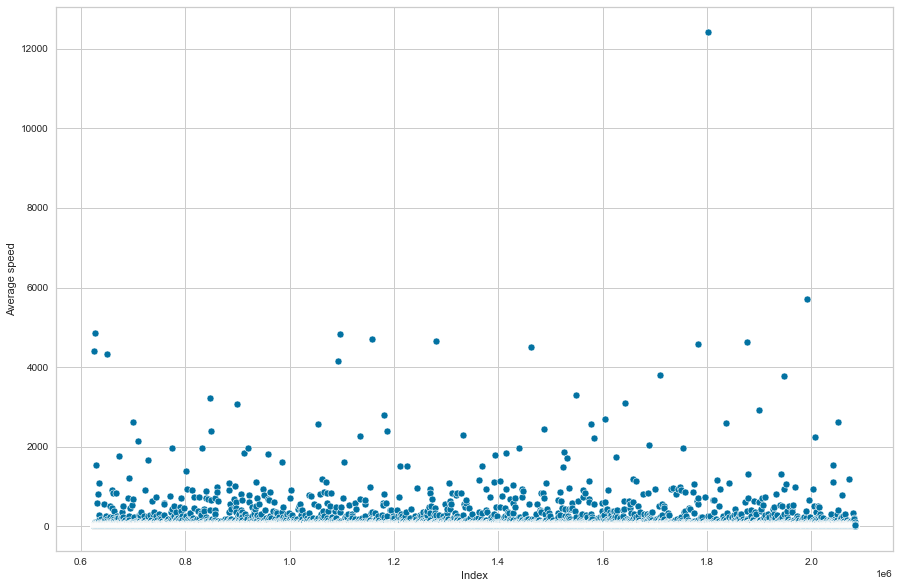

In [34]:
# update train mask 
train_mask = data[data['sample'] == 1] 

# calculate average speed for the train sample
avg_speed = train_mask['total_distance'] / train_mask['trip_duration'] * 3.6

# picturaze
fig, ax = plt.subplots(figsize=(15,10))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed');

We see that we have trips for which the average speed is over 1000 km/h! Remove all single-digit outliers:
- average speeds over 300 km/h
- the duration of the trip is more than a day

In [35]:
# get rid of outliers - only for the train sample
cleaned_data = train_mask[avg_speed <= 300]

# point the test sample
test = data[data['sample'] == 0]

# join cleaned train and test samples
cleaned_data = pd.concat([cleaned_data, test])

# update data with cleaned duration and average speed
data = cleaned_data[cleaned_data['trip_duration'] <= 86400]

## <center> **Part III. Exploratory Data Analysis**

The main quality metric for solving the problem is RMSLE (Root Mean Squared Log Error), which is calculated based on the target variable on a logarithmic scale. Therefore, we immediately take the logarithm of the criterion for the duration of the trip. This will be the target.

In [36]:
# create new target feature with log
data['log_trip_duration'] = np.log(data['trip_duration'] + 1)

C:\Users\volod\AppData\Local\Temp\ipykernel_7028\2007114980.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['log_trip_duration'] = np.log(data['trip_duration'] + 1)


We will evaluate the influence of various features on the duration of the trip known to us. Thus, we work only with the training part.

In [37]:
# update train mask
train_mask = data[data['sample'] == 1] 

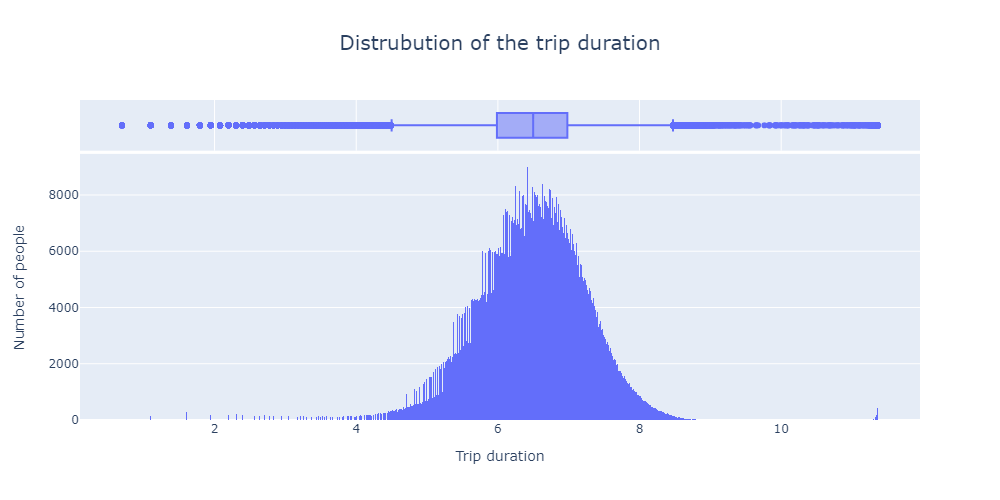

In [38]:
# let's explore this feature with visualization
box_hist_duration = px.histogram(
    data_frame=train_mask,
    x='log_trip_duration',
    title='Distrubution of the trip duration',
    marginal='box'
)

# add names
box_hist_duration.update_layout(
    xaxis_title="Trip duration",
    yaxis_title='Number of people',
    title_font_size=20,
    width=1000,
    title=dict(x=0.5, xanchor='center')
)

# display this graph
box_hist_duration.show('png')

The distribution seems to be normal. Let's check it with D'Agostino-Pearson Test.

In [39]:
# define hypothesis
Ho = 'The distribution is normal.'
Ha = 'Distribution is not normal.'

# define the significance level
alpha = 0.05

# will use the Shapiro-Wilk test
# calculate results for borh samples
normaltest_result = normaltest(train_mask['log_trip_duration'])

# display p-values for both samples
print('p-value группы А', round(normaltest_result.pvalue, 2))

# display results of test
if normaltest_result.pvalue < alpha:
    print('We accept the alternative hypothesis. {}'.format(Ha))
    
else:
    print('We accept the null hypothesis. {}'.format(Ho))

p-value группы А 0.0
We accept the alternative hypothesis. Distribution is not normal.


Now let's compare the distribution of the sign of the duration of the trip on a logarithmic scale, depending on the taxi company.

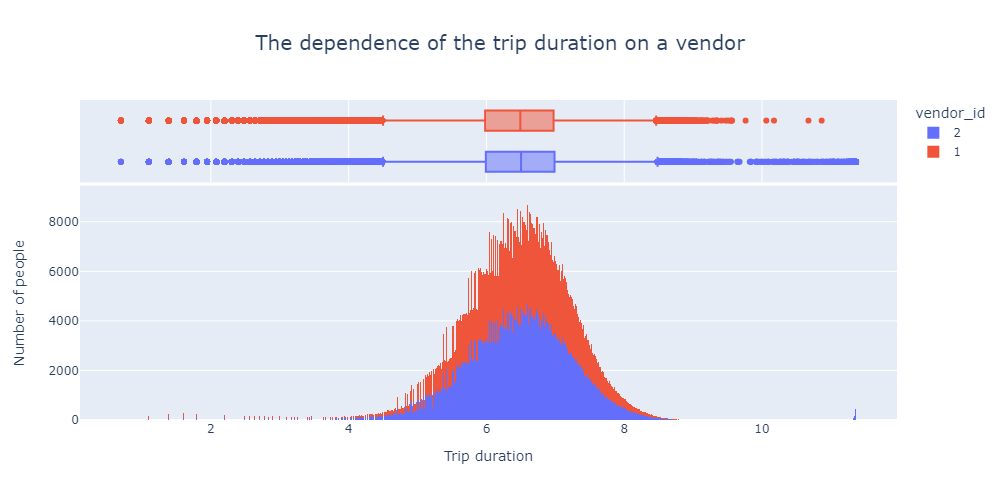

In [40]:
# build a graph
box_hist_vendor = px.histogram(
    data_frame=train_mask,
    x='log_trip_duration',
    color='vendor_id',
    title='The dependence of the trip duration on a vendor',
    marginal='box'
)

# add names
box_hist_vendor.update_layout(
    xaxis_title="Trip duration",
    yaxis_title='Number of people',
    title_font_size=20,
    width=1000,
    title=dict(x=0.5, xanchor='center')
)

# display the graph
box_hist_vendor.show('png')

The distributions in the groups practically do not differ, the vendor_id attribute does not matter when determining the duration of the trip. Which is generally logical, because different taxi companies are unlikely to differ significantly in any criteria for a trip other than their number.

At this time, let's compare the distribution of the trip duration on a logarithmic scale, depending on the sign of sending a message to the taxi company.

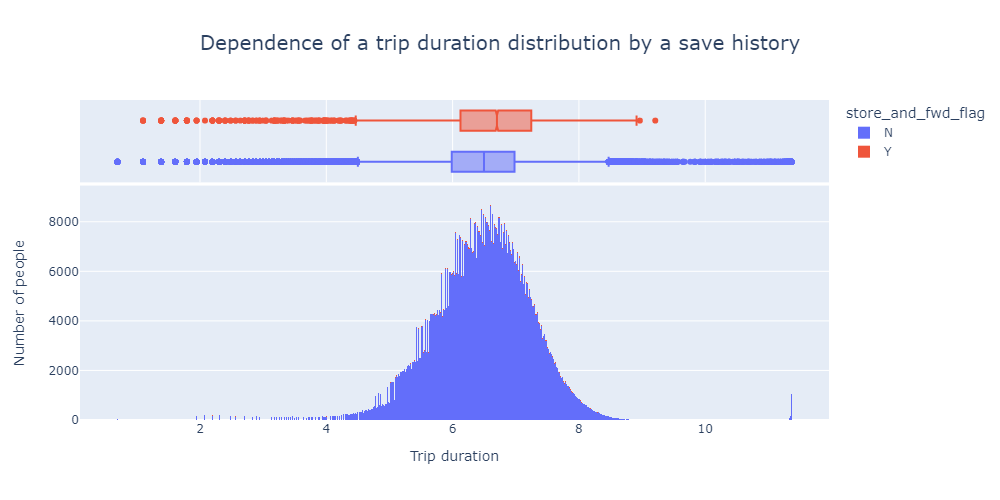

In [41]:
# build a graph
box_hist_flag = px.histogram(
    data_frame=train_mask,
    x='log_trip_duration',
    color='store_and_fwd_flag',
    title='Dependence of a trip duration distribution by a save history',
    marginal='box'
)

# add names
box_hist_flag.update_layout(
    xaxis_title="Trip duration",
    yaxis_title='Number of people',
    title_font_size=20,
    width=1000,
    title=dict(x=0.5, xanchor='center')
)

# display the graph
box_hist_flag.show('png')

If you look closely at the distribution of trip duration depending on the store_and_fwd_flag feature, it becomes clear that the longest trips belong to group N (do not store or forward a trip). Thus, the flag is preserved only for short-term trips, and for anomalous many-hour trips it is not preserved.

Let's picturaze the distribution of the number of trips depending on the hour of the day.

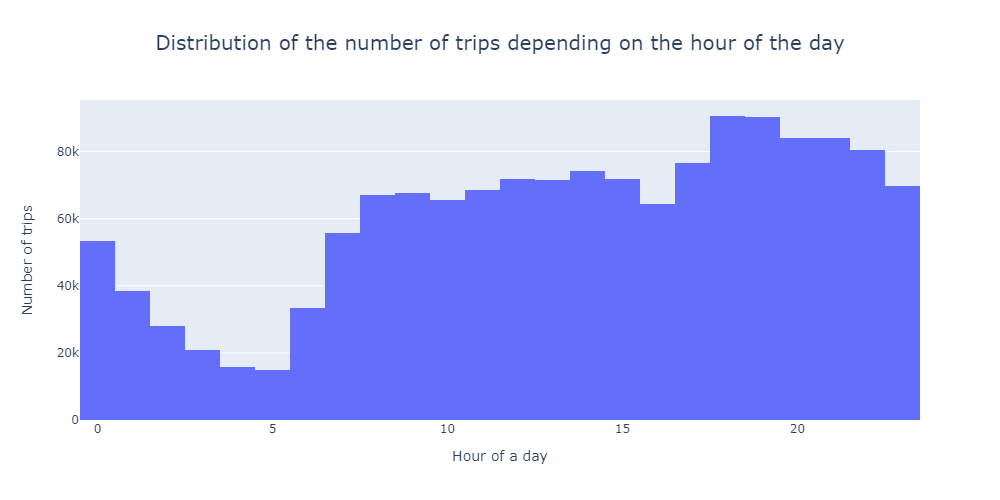

In [42]:
# build a graph
pickup_hour_distribution = px.histogram(
    data_frame=train_mask,
    x='pickup_hour',
    title='Distribution of the number of trips depending on the hour of the day',
)

# add names
pickup_hour_distribution.update_layout(
    xaxis_title="Hour of a day",
    yaxis_title='Number of trips',
    title_font_size=20,
    width=1000,
    title=dict(x=0.5, xanchor='center')
)

# show
pickup_hour_distribution.show('png')

Let us estimate the dependence of the median trip duration on the hour of the day.

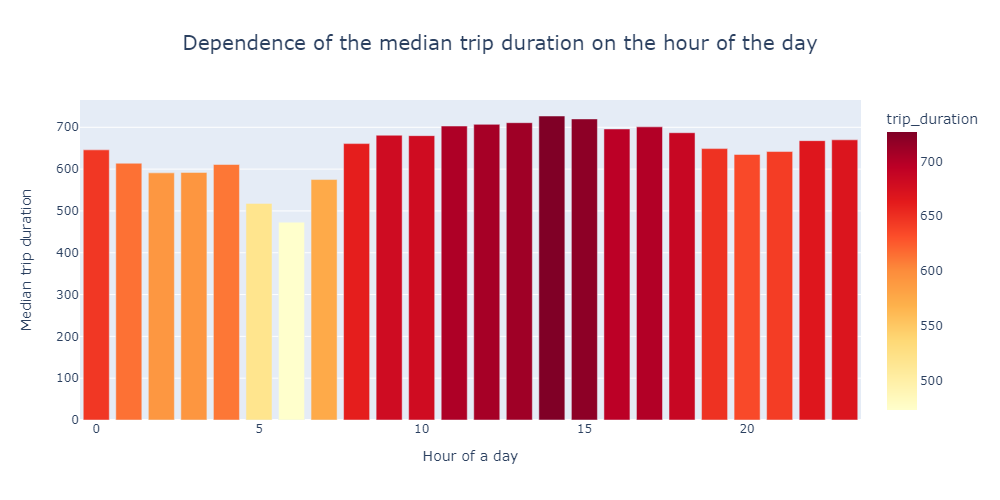

In [43]:
# group the data
traffic_grouped = train_mask.groupby('pickup_hour', as_index=False)['trip_duration'].median()

# build a graph
traffic_distribution = px.bar(
    data_frame=traffic_grouped,
    x='pickup_hour',
    color='trip_duration',
    color_continuous_scale='ylorrd',
    y='trip_duration',
    title='Dependence of the median trip duration on the hour of the day'    
)

# add names
traffic_distribution.update_layout(
    xaxis_title="Hour of a day",
    yaxis_title='Median trip duration',
    title_font_size=20,
    width=1000,
    title=dict(x=0.5, xanchor='center')
)

# show the graph
traffic_distribution.show('png')

Let us estimate the distribution of the number of trips depending on the day of the week.

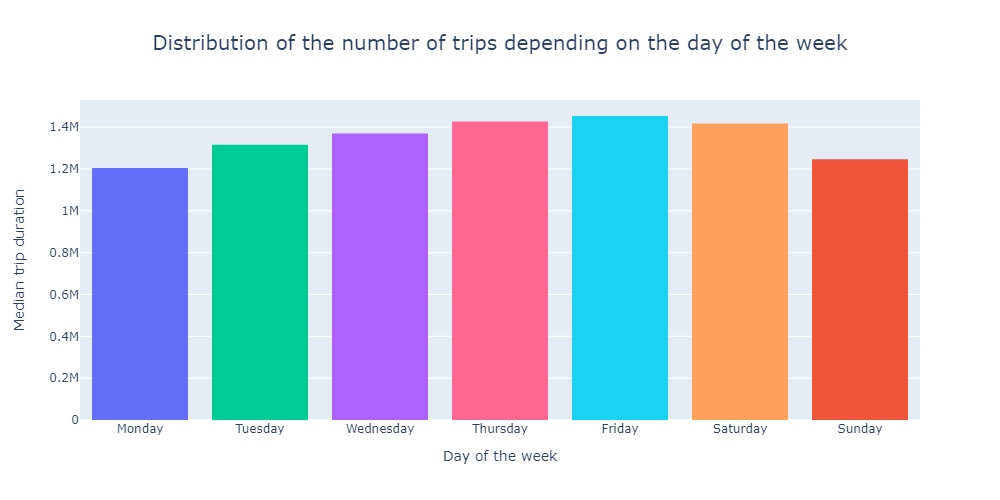

In [44]:
# list of days of the week in order
day_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# build a graph
day_of_week_distribution = px.histogram(
    data_frame=train_mask,
    x='pickup_day_of_week',
    color='pickup_day_of_week',
    y='log_trip_duration',
    title='Distribution of the number of trips depending on the day of the week',
)

# add names
day_of_week_distribution.update_layout(
    xaxis={'categoryarray': day_of_week},
    xaxis_title='Day of the week',
    yaxis_title='Median trip duration',
    title_font_size=20,
    width=1000,
    title=dict(x=0.5, xanchor='center'),
    showlegend=False
)

# show the graph
day_of_week_distribution.show('png')

It is expected that taxis are most often called on Friday.

Does the median trip duration depend on the day of the week?

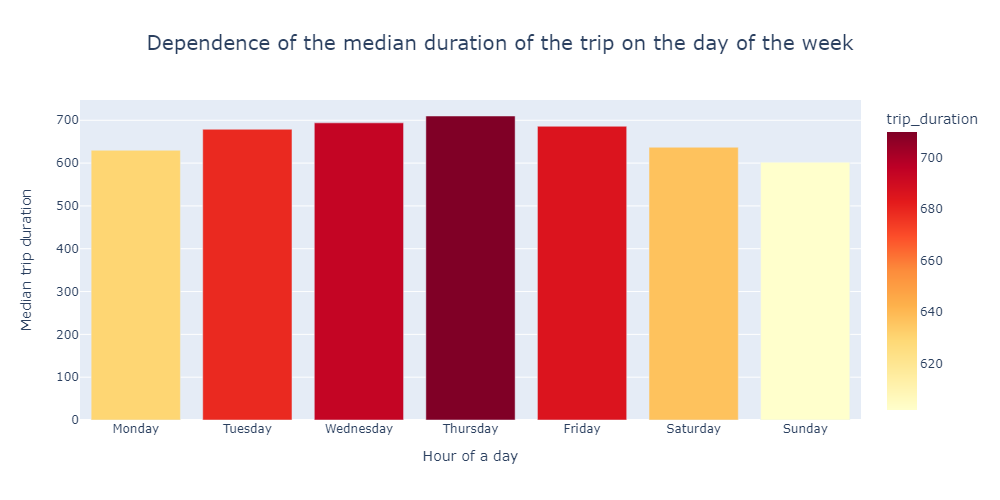

In [45]:
# group the data
day_of_week_grouped = train_mask.groupby('pickup_day_of_week', as_index=False)['trip_duration'].median()

# build a graph
day_week_duration = px.bar(
    data_frame=day_of_week_grouped,
    x='pickup_day_of_week',
    color='trip_duration',
    color_continuous_scale='ylorrd',
    y='trip_duration',
    title='Dependence of the median duration of the trip on the day of the week'  
)

# add names
day_week_duration.update_layout(
    xaxis={'categoryarray':day_of_week},
    xaxis_title="Hour of a day",
    yaxis_title='Median trip duration',
    title_font_size=20,
    width=1000,
    title=dict(x=0.5, xanchor='center')
)

# show the graph
day_week_duration.show('png')

And the median trip duration is the shortest on Sunday, which is most likely due to low traffic.

Now let's evaluate the influence of both time characteristics simultaneously on the median trip duration using a heat map.

In [46]:
# group data
hour_week_median_df = train_mask.pivot_table(
    values='trip_duration',
    index='pickup_hour',
    columns='pickup_day_of_week',
    aggfunc='median'
)

# sort by day of the week
hour_week_median_df = hour_week_median_df[day_of_week]

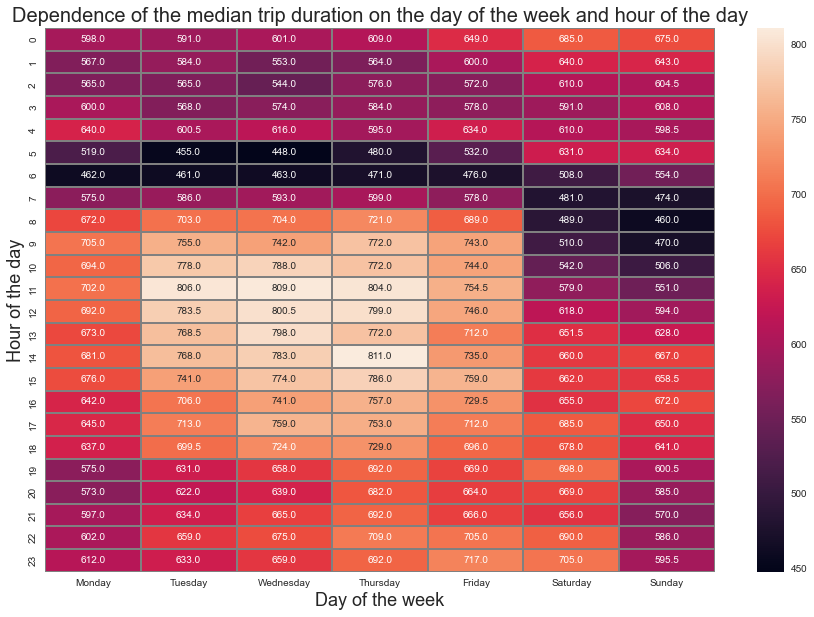

In [47]:
# create an axis
fig, ax = plt.subplots(figsize=(15, 10))

# build a heatmap
hour_week_heatmap = sns.heatmap(
    hour_week_median_df,
    annot=True,
    fmt='.1f',
    linewidths=0.1,
    linecolor="gray",
    cbar="coolwarm",
    ax=ax,
)

# adding axis labels
hour_week_heatmap.set_title('Dependence of the median trip duration on the day of the week and hour of the day', fontsize=20)
hour_week_heatmap.set_xlabel('Day of the week', fontsize=18)
hour_week_heatmap.set_ylabel('Hour of the day', fontsize=18);

## <center> **Part IV. Selection and transformation of features**

Let's get rid of the non-informative sign (id) and data leakage. The sign of the end time of the trip in reality will be unknown to us.

In [48]:
# discard these features
data = data.drop(['dropoff_datetime', 'id'], axis=1)

Previously, we extracted all the necessary information from the start date of the trip. Now we can get rid of these signs, since we will no longer need them.

In [49]:
# get rid of useless features
data = data.drop(['pickup_datetime', 'pickup_date'], axis=1)

In [50]:
# encoding binary features
data['vendor_id'] = data['vendor_id'].apply(lambda x: 0 if x==1 else 1)
data['store_and_fwd_flag'] = data['store_and_fwd_flag'].apply(lambda x: 0 if x=='N' else 1)

In [51]:
# nominal features are encoded by dummies
data = pd.get_dummies(data, columns=['pickup_day_of_week', 'geo_cluster', 'events'])

In [52]:
# encoding streets features
binary_encoder = BinaryEncoder()
cols = ['starting_street', 'end_street']
add_cols = binary_encoder.fit_transform(data[cols])

# join new features
data = pd.concat([data, add_cols], axis=1)

# get rid of useless features
data = data.drop(['starting_street', 'end_street'], axis=1)

### **Check correlation**

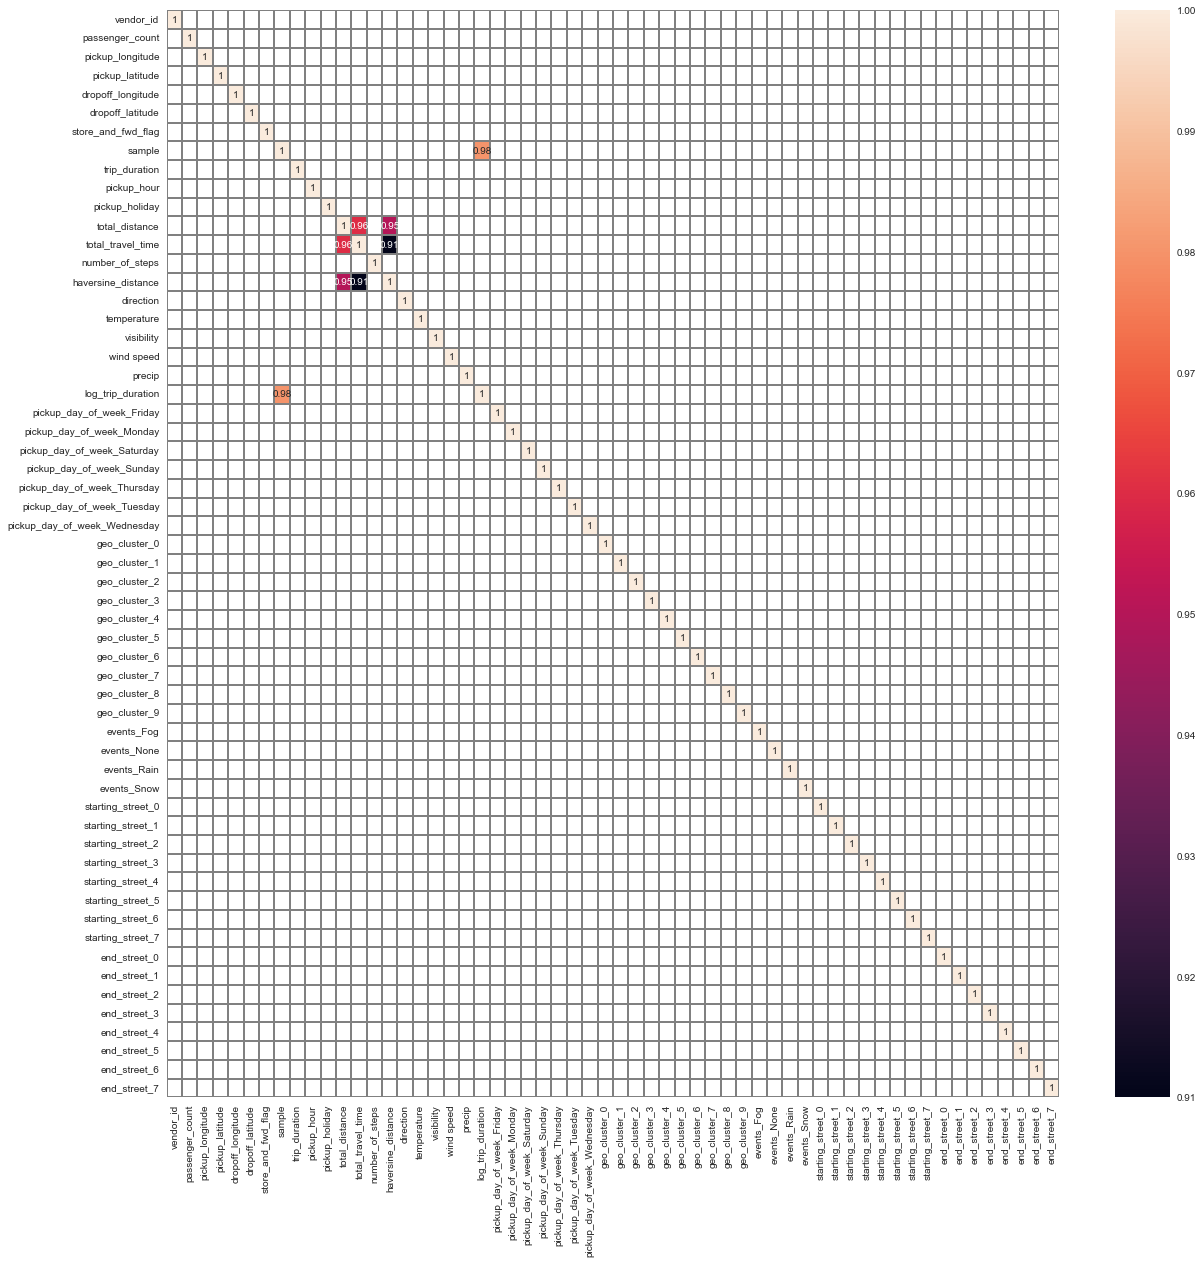

In [53]:
corr = data.corr()
fig = plt.figure(figsize=(20,20))
sns.heatmap(round(corr[corr.abs() > 0.9], 2), annot=True, linewidths=0.1, linecolor="gray");

### **Impact on the target value**

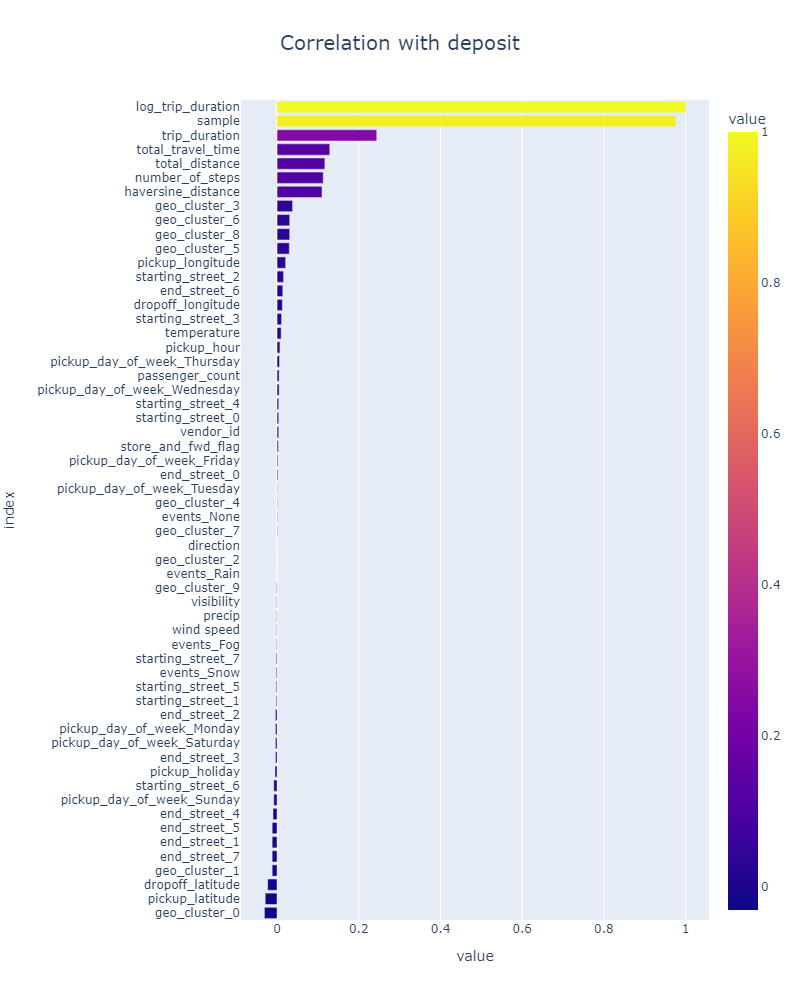

In [54]:
# now let's see the correlation with the target feature
# group data
corr_df = round(corr['log_trip_duration'].sort_values(ascending=True), 3)

# picturaze
deposit_corr = px.bar(
    data_frame=corr_df,
    orientation='h',
    color='value',
    height=1000,
    width=800,
    title='Correlation with deposit'
)
deposit_corr.update_layout(title=dict(x=.5, xanchor='center'),
                           title_font_size=20)

# display
deposit_corr.show('png')

Removing multicollinear features and features with a low impact on the target metric leads to a deterioration in the final result of the model.

## <center> **Part V. Machine Learning**

At the beginning, let's divide the sample into test and training using a pre-created feature.

In [55]:
# test sample
test_sample = data[data['sample'] == 0]

# create X 
X_test = test_sample.drop(['sample', 'trip_duration', 'log_trip_duration'], axis=1)

# create y and y_log
y_test = test_sample['trip_duration']
y_test_log = test_sample['log_trip_duration']

Now let's select the training part.

In [56]:
# extract predictors
train_sample = data[data['sample'] == 1]
X = train_sample.drop(['sample', 'trip_duration', 'log_trip_duration'], axis=1)

# extract y and its log version
y = train_sample['trip_duration']
y_log = train_sample['log_trip_duration']

Now it's time to divide the sample for the дуфктштп into training and validation.  
We will train the model on the training data set, evaluate the quality of the model on the validation one, and predict the final values for the Kaggle on the test one.

In [57]:
# split our data
X_train, X_valid, y_train_log, y_valid_log = train_test_split(X, y_log, test_size=0.33, random_state=42)

In [58]:
# scaling
scaler = MinMaxScaler()

# training on the train sample
scaler.fit(X_train)

# transforming both samples
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [59]:
def rmsle(y, y_pred):
    """func to calculate the main metric rmsle"""
    
    rmsle = metrics.mean_squared_error(y, y_pred, squared=False)
    
    return rmsle

### Gradient Boosting

In [60]:
# build a model with best parameters
gbr = ensemble.GradientBoostingRegressor(
    learning_rate=0.5,
    n_estimators=100,
    max_depth=6,
    min_samples_leaf=30,
    random_state=42,
    verbose=True
)

# train the model
gbr.fit(X_train, y_train_log)

# predict and calculate the metric for the train sample     
y_train_pred = gbr.predict(X_train)
print('Train RMSLE: {:.4f}'.format(rmsle(y_train_log, y_train_pred)))

# predict and calculate the metric for the valid sample  
y_valid_pred = gbr.predict(X_valid)
print('Valid RMSLE: {:.4f}'.format(rmsle(y_valid_log, y_valid_pred)))

      Iter       Train Loss   Remaining Time 
         1           0.3110           20.21m
         2           0.2245           19.61m
         3           0.1979           19.23m
         4           0.1864           19.07m
         5           0.1804           18.80m
         6           0.1758           18.60m
         7           0.1724           18.37m
         8           0.1687           18.21m
         9           0.1672           17.87m
        10           0.1660           17.58m
        20           0.1561           15.17m
        30           0.1514           13.08m
        40           0.1475           11.17m
        50           0.1448            9.32m
        60           0.1426            7.45m
        70           0.1412            5.59m
        80           0.1394            3.72m
        90           0.1382            1.86m
       100           0.1369            0.00s
Train RMSLE: 0.3700
Valid RMSLE: 0.3875


Despite all the advantages, the RMSLE metric has one drawback - it is not interpretable. We would like to understand how well our final model predicts the target feature from a business process point of view. More specifically, we would like to have a better understanding of the trip duration prediction error.

In [62]:
# cancel log for y_true and y_pred
cancel_log = np.vectorize(lambda x: np.exp(x) - 1)
y_valid, y_valid_pred = cancel_log(y_valid_log), cancel_log(y_valid_pred)

# calculate  MeAE for the valid sample
print('Valid MeAE: {:.4f}'.format(metrics.median_absolute_error(y_valid, y_valid_pred)))

Valid MeAE: 108.7481


Well, our best model showed an average median error for a trip duration of less than 2 minutes.

### Submission

In [63]:
test_id = test_data['id']

# predict result for the test sample
y_test_pred = gbr.predict(X_test)

# tranform from log to normal
y_test_pred = cancel_log(y_test_pred)

In [64]:
submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_pred})
submission.to_csv('final_submission.csv', index=False)

## <center> **Conclusion**

The best result was shown by the gradient boosting model. The median absolute error of the model is less than 2 minutes.